# COVID-19 Data Mining

## Import Libraries

In [2]:
# Data Manipulation
import pandas as pd 
import numpy as np
import math
from scipy import integrate, optimize
from sklearn import preprocessing
from datetime import timedelta

In [3]:
# Data Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

In [23]:
# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Define palette of colors 
red = '#ff4d4d'
green = '#64e764'
blue = '#3eb0f7'
yellow = '#f1c900'
yellowGreen ='#ddf100'
purple = '#cc00cc'
greenBlue = '#0eb194'
lightGrey = '#b0b0b0'
pink = '#ff748c'
orange = '#ffb327'

## Load data and Preprocessing

In [6]:
df = pd.read_csv('C:/Users/m.rachidi/Desktop/Tableau_Country.csv', sep=';', encoding='latin-1', parse_dates=['Date'])
df

,PK_Country,Country,Country_code,Date,Confirmed,Recovered,Deaths,Active,New_Confirmed,Last_7Days,New_Recovered,New_Deaths,Death_Rate,New_Active,FK_Date,FK_Rest_Country
0,1,Afghanistan,AF,2020-01-22,0,0,0,0,0,0,0,0,0,0,20200122,1
1,2,Afghanistan,AF,2020-01-23,0,0,0,0,0,0,0,0,0,0,20200123,1
2,3,Afghanistan,AF,2020-01-24,0,0,0,0,0,0,0,0,0,0,20200124,1
3,4,Afghanistan,AF,2020-01-25,0,0,0,0,0,0,0,0,0,0,20200125,1
4,5,Afghanistan,AF,2020-01-26,0,0,0,0,0,0,0,0,0,0,20200126,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197,17198,Zimbabwe,ZW,2020-04-20,25,2,3,20,0,8,0,0,0,0,20200420,250
17198,17199,Zimbabwe,ZW,2020-04-21,28,2,3,23,3,11,0,0,0,3,20200421,250
17199,17200,Zimbabwe,ZW,2020-04-22,28,2,4,22,0,5,0,1,"7,0223890617020807E-2",-1,20200422,250
17200,17201,Zimbabwe,ZW,2020-04-23,28,2,4,22,0,5,0,0,0,0,20200423,250


In [7]:
# Add days column
df['DayOne'] = df['Date'].min()
df['Days'] = (df['Date'] - df['DayOne']).dt.days

# Replace country values to match rest country 
replace_values = {'Bolivia':'Bolivia (Plurinational State of)','Cape Verde':'Cabo Verde',
                  'Congo (Brazzaville)':'Congo','Congo (Kinshasa)':'Congo (Democratic Republic of the)',
                  'Holy See (Vatican City State)':'Holy See','Iran, Islamic Republic of':'Iran (Islamic Republic of)',
                  'Korea (South)':'Korea (Republic of)','Lao PDR':'Lao People\'s Democratic Republic',
                  'Macedonia, Republic of':'Macedonia (the former Yugoslav Republic of)','Moldova':'Moldova (Republic of)',
                  'Palestinian Territory':'Palestine, State of','Saint Vincent and Grenadines':'Saint Vincent and the Grenadines',
                  'Syrian Arab Republic (Syria)':'Syrian Arab Republic','Taiwan, Republic of China':'Taiwan', 
                  'United Kingdom':'United Kingdom of Great Britain and Northern Ireland',
                  'Venezuela (Bolivarian Republic)':'Venezuela (Bolivarian Republic of)'}

df['Country'] = df['Country'].replace(replace_values)



In [8]:
# Import RestCountries Dataset
rest_country = pd.read_excel('C:/Users/m.rachidi/Desktop/Tableau_RestCountry.xls')

# Get desired columns and rename them
rest_countries = rest_country[['Name','Alpha_2_Code','Region','Population','Latitude','Longitude','Area','Gini']]
rest_countries.columns = ['Country_name','Country_code','Region', 'Population','Latitude','Longitude','Area','Gini']
rest_countries['Density'] = rest_countries['Population']/rest_countries['Area']

df = pd.merge(df, rest_countries, on='Country_code', how='left')
df = df.drop(columns=['Country_name','Active','New_Active','FK_Date','FK_Rest_Country'])
df

,PK_Country,Country,Country_code,Date,Confirmed,Recovered,Deaths,New_Confirmed,Last_7Days,New_Recovered,...,Death_Rate,DayOne,Days,Region,Population,Latitude,Longitude,Area,Gini,Density
0,1,Afghanistan,AF,2020-01-22,0,0,0,0,0,0,...,0,2020-01-22,0,Asia,27657145,33.0,65.0,652230.0,27.8,42.403976
1,2,Afghanistan,AF,2020-01-23,0,0,0,0,0,0,...,0,2020-01-22,1,Asia,27657145,33.0,65.0,652230.0,27.8,42.403976
2,3,Afghanistan,AF,2020-01-24,0,0,0,0,0,0,...,0,2020-01-22,2,Asia,27657145,33.0,65.0,652230.0,27.8,42.403976
3,4,Afghanistan,AF,2020-01-25,0,0,0,0,0,0,...,0,2020-01-22,3,Asia,27657145,33.0,65.0,652230.0,27.8,42.403976
4,5,Afghanistan,AF,2020-01-26,0,0,0,0,0,0,...,0,2020-01-22,4,Asia,27657145,33.0,65.0,652230.0,27.8,42.403976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197,17198,Zimbabwe,ZW,2020-04-20,25,2,3,0,8,0,...,0,2020-01-22,89,Africa,14240168,-20.0,30.0,390757.0,NaN,36.442515
17198,17199,Zimbabwe,ZW,2020-04-21,28,2,3,3,11,0,...,0,2020-01-22,90,Africa,14240168,-20.0,30.0,390757.0,NaN,36.442515
17199,17200,Zimbabwe,ZW,2020-04-22,28,2,4,0,5,0,...,"7,0223890617020807E-2",2020-01-22,91,Africa,14240168,-20.0,30.0,390757.0,NaN,36.442515
17200,17201,Zimbabwe,ZW,2020-04-23,28,2,4,0,5,0,...,0,2020-01-22,92,Africa,14240168,-20.0,30.0,390757.0,NaN,36.442515


## The SIR epidemic model

In [9]:
# Get variables of SIR model

# Population
N = 1000

# Initial Values                 # Starts with :
I0 = 1                           # first individual to get infected 
R0 = 0                           # no recovered
S0 = N - I0 - R0                 # rest of population are suspected

# Initial parameters
beta = 0.2
gamma = 1./10

# Days values 
t = np.arange(1,160,1)

# SIR model differential equations
def SIR_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = (-beta * S * I) / N
    dIdt = (beta * S * I) / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = integrate.odeint(SIR_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [10]:
df_model = pd.DataFrame(ret, columns=['Susceptible', 'Infected', 'Recovered'])
df_model['Days'] = t
df_model

,Susceptible,Infected,Recovered,Days
0,999.000000,1.000000,0.000000,1
1,998.789913,1.104927,0.105159,2
2,998.557840,1.220810,0.221350,3
3,998.301495,1.348781,0.349724,4
4,998.018364,1.490085,0.491551,5
...,...,...,...,...
154,204.561982,2.496140,792.941879,155
155,204.462842,2.352898,793.184261,156
156,204.369435,2.217834,793.412731,157
157,204.281431,2.090484,793.628084,158


In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_model['Days'], y=df_model['Susceptible'], name='Susceptible'))
fig.add_trace(go.Scatter(x=df_model['Days'], y=df_model['Infected'], name='Infected'))
fig.add_trace(go.Scatter(x=df_model['Days'], y=df_model['Recovered'], name='Recovered'))

fig.update_traces(mode='lines', line_width=4)
fig.update_layout(title='SIR Model', xaxis_title='Time', yaxis_title='Number(population)', height=600)
fig.show()

## Fit real data to SIR model

Optimal parameters: beta = 7.94527377475604  and gamma =  7.810930678262984


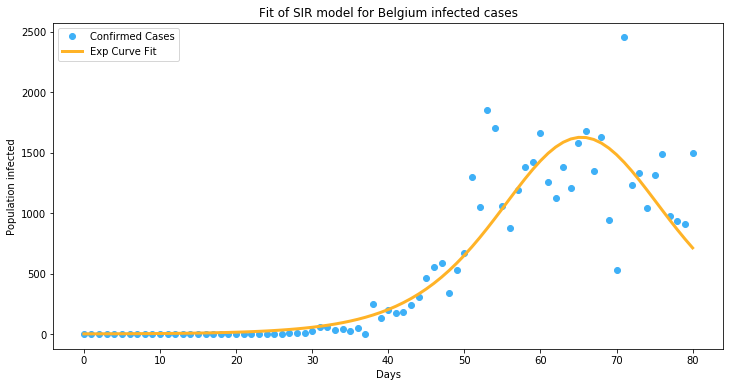

In [77]:
# Select a country to estimate
belgium = df[(df['Country']=='Belgium') & (df['Confirmed']>0)]
spain = df[(df['Country']=='Spain') & (df['Confirmed']>0)]

# Get population
population = belgium['Population'].max()
N = population

# Get time period
belgium['Days'] = (belgium['Date'] - (belgium['Date'].min())).dt.days
spain['Days'] = (spain['Date'] - (spain['Date'].min())).dt.days
x = belgium['Days']

# Set initial conditions
y = belgium['New_Confirmed']
I0 = y.iloc[0]                  # Get the first Covid case in Belgium
S0 = N - I0
R0 = 0

# Define Model to fit
def sir_model(y, x, beta, gamma):
    S, I, R = y
    dSdt = (-beta * S * I) / N
    dIdt = (beta * S * I) / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define fit function to solve a differential equation
def fit_odeint(x, beta, gamma):
    fit = integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))
    df_fit = pd.DataFrame(fit, columns=['Susceptible','Infected','Recovered'])
    return df_fit['Infected']

# Get optimal parameters (beta, gamma) to pass in fit function: popt= param optimal, pcov= param covariance
popt, pcov = optimize.curve_fit(fit_odeint, x, y)
y_fit = fit_odeint(x, popt[0], popt[1])

# Plot results
plt.figure(figsize=(12,6))
plt.plot(x, y, 'o', label='Confirmed Cases', color=blue)
plt.plot(x, y_fit, label='Exp Curve Fit', color=orange,lw=3)
plt.title("Fit of SIR model for Belgium infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.legend()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y, name='Confirmed Cases (Daily)', mode='markers', 
#                          marker_color=blue, marker_size=10, marker_line_width=2))
# fig.add_trace(go.Scatter(x=x, y=fitted, name='Curve Fit', mode='lines', line_width=3, line_color=orange))
# fig.update_layout(title='Fit of SIR model for Belgium infected cases', xaxis_title='Time', yaxis_title='Number(population)')
# fig.show()

#### Growth Factor 

In [14]:
table = df.copy()
features = ['Country','Country_code','Date','Days','Confirmed','Deaths','New_Confirmed','New_Deaths']
table = table[features]

# Get data from the first confirmed case
table = table[table['Confirmed']>2]

# Calculate lags x(t-1)
table['Confirmed_Lag1'] = table['Confirmed'].shift(1)
table['Deaths_Lag1'] = table['Deaths'].shift(1)

table['New_Confirmed_Lag1'] = table['New_Confirmed'].shift(1)
table['New_Deaths_Lag1'] = table['New_Deaths'].shift(1)

# Filter and Replace data where previous country != current country
mask = table['Country'] != table['Country'].shift(1) # IF lag country not equal to the previous country --> THEN mask = True
table.loc[mask, 'Confirmed_Lag1'] = 0.0
table.loc[mask, 'Deaths_Lag1'] = 0.0
table.loc[mask, 'New_Confirmed_Lag1'] = 0.0
table.loc[mask, 'New_Deaths_Lag1'] = 0.0

#-----------------------------------------------------------------------------------------------------------------------------#
# Growth Factor = new confirmed(t) / new confirmed(t-1) 
table['Growth_Factor'] = table['New_Confirmed'] / table['New_Confirmed_Lag1']
table.replace([np.nan, np.inf, -np.inf], 1, inplace=True)
#---> GF > 1 = Outbreaking || GF < 1 = Stopping | GF = 1 

# Plot results
df_country = table[table['Country']=='Belgium']

fig = px.line(df_country, x='Days', y='Growth_Factor', width=800, height=400)
fig.add_shape(type= 'line', yref= 'y', y0= 1, y1= 1, xref= 'x', x0= 93, x1= 0,
              line=dict(color=lightGrey, width=2))
fig.show()

In [15]:
df_world = df.groupby('Days')['Confirmed','Deaths','New_Confirmed','New_Deaths'].sum().reset_index()

# Get data from the first confirmed case
df_world = df_world[df_world['Confirmed']>2]

# Calculate lags x(t-1)
df_world['Confirmed_Lag1'] = df_world['Confirmed'].shift(1).fillna(0)
df_world['Deaths_Lag1'] = df_world['Deaths'].shift(1).fillna(0)

df_world['New_Confirmed_Lag1'] = df_world['New_Confirmed'].shift(1).fillna(0)
df_world['New_Deaths_Lag1'] = df_world['New_Deaths'].shift(1).fillna(0)

# Growth Factor = new confirmed(t) / new confirmed(t-1) 
df_world['Growth_Factor'] = df_world['New_Confirmed'] / df_world['New_Confirmed_Lag1']
df_world.replace([np.nan, np.inf, -np.inf], 1, inplace=True)
#---> GF > 1 = Outbreaking || GF < 1 = Stopping | GF = 1 

# Plot results

fig = px.line(df_world, x='Days', y='Growth_Factor', width=800, height=400)
fig.add_shape(type= 'line', yref= 'y', y0= 1, y1= 1, xref= 'x', x0= 93, x1= 0,
              line=dict(color=lightGrey, width=2))
fig.show()

#### Growth Ratio 

In [16]:
# Growth Ratio = confirmed(t) / confirmed(t-1)
table['Growth_Ratio'] = table['Confirmed'] / table['Confirmed_Lag1']
table.replace([np.nan, np.inf, -np.inf], 1, inplace=True)

# Plot results
df_country = table[table['Country']=='Belgium']

fig = px.line(df_country, x='Days', y='Growth_Ratio', width=800, height=400)
fig.add_shape(type= 'line', yref= 'y', y0= 1, y1= 1, xref= 'x', x0= 93, x1= 0,
              line=dict(color=lightGrey, width=2))
fig.show()

#### First Derivative

In [17]:
# Second Derivative
table['2nd_Derivative'] = np.gradient(table['Confirmed'])

# Plot results
df_country = table[table['Country']=='Belgium']

fig = px.line(df_country, x='Days', y='2nd_Derivative', width=800, height=400)
fig.add_shape(type= 'line', yref= 'y', y0= 0, y1= 0, xref= 'x', x0= 93, x1= 0,
              line=dict(color=lightGrey, width=2))
fig.show()

#### Second Derivative

In [18]:
# Second Derivative
table['2nd_Derivative'] = np.gradient(np.gradient(table['Confirmed']))

# Plot results
df_country = table[table['Country']=='Belgium']

fig = px.line(df_country, x='Days', y='2nd_Derivative', width=800, height=400)
fig.add_shape(type= 'line', yref= 'y', y0= 0, y1= 0, xref= 'x', x0= 93, x1= 0,
              line=dict(color=lightGrey, width=2))
fig.show()


#### Trends

In [19]:
# Trends x(t) - x(t-1)/x(t-1)
table['Trend'] = (table['Confirmed'] - table['Confirmed_Lag1']) / table['Confirmed_Lag1']
table.replace([np.nan, np.inf, -np.inf], 1, inplace=True)

# Plot results
df_country = table[table['Country']=='Germany']

fig = px.line(df_country, x='Days', y='Trend', width=800, height=400)
fig.show()

### Data Enrichment

In [20]:
# # import information about population (urban_rate)
# world_countries = pd.read_csv('C:/Users/m.rachidi/Desktop/population_by_country_2020.csv')
# world_countries.sort_values('Country (or dependency)')
# world_countries = world_countries.rename(columns=
#                                 {'Country (or dependency)':'Country','Population (2020)':'Population_2020',
#                                 'Density (P/Km²)':'Density_2020','Land Area (Km²)':'Land_Area','Migrant (net)':'Migrant',
#                                 'Fert. Rate':'Fertility Rate','Urban Pop %':'Urban_Rate','World Share':'World_Share',
#                                 'Med. Age':'Medium_Age'})

# world_countries = world_countries[['Country','Population_2020','Density_2020','Land_Area','Medium_Age','Urban_Rate']]
# world_countries

# df = df.merge(world_countries, left_on='Country', right_on='Country', how='left')
# df

# # Clean missing values for df
# null_df = df[df.isnull().any(axis=1)]
# null_df

# # Namibia (NA)
# df["Country_code"].fillna("NA", inplace = True)

# # Gini, Density and Area
# df['Gini'].fillna(0.0, inplace = True)
# df['Density'].fillna(0.0, inplace = True)
# df['Area'].fillna(0.0, inplace = True)

# # Latitude and Longitude
# df['Latitude'].fillna(0.0, inplace = True)
# df['Longitude'].fillna(0.0, inplace = True)

# # Region
# df["Region"].fillna("Unknown", inplace = True)
# null_df

### Prediction using Machine Learning Models

#### Preprocessing

Text(0.5, 1.0, 'Train/Test Confirmed Cases')

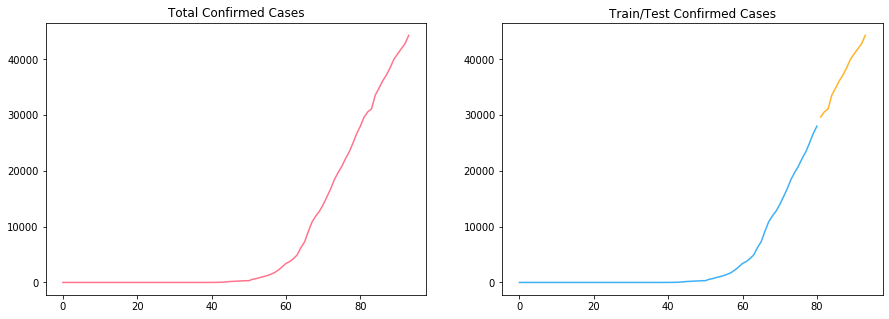

In [22]:
data = df.copy()

# Choose a country to predict 
df_country = data[data['Country']=='Belgium']
X = df_country['Days']
y = df_country['Confirmed']

# Set train/test split for predicition
train_lim = 80
train = df_country[df_country['Days'] <= train_lim]
test = df_country[df_country['Days'] > train_lim]

# Set initial conditions
X_train = train['Days']
y_train_c = train['Confirmed']

X_test = test['Days'] 
y_test_c = test['Confirmed']

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(X,y, color=pink)
ax1.set_title('Total Confirmed Cases')

ax2.plot(X_train,y_train_c, label="Train", color=blue)
ax2.plot(X_test,y_test_c, label="Test", color=orange)
ax2.set_title('Train/Test Confirmed Cases')


#### Linear Regression 

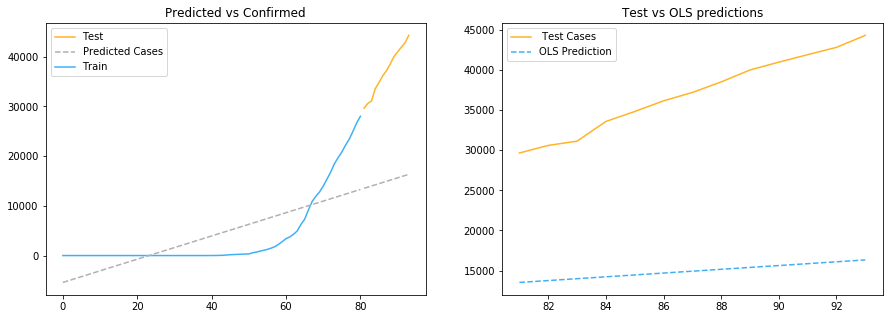

In [24]:
# Linear Regression Model
reg = LinearRegression(normalize=True)

# Train the Model
fit = reg.fit(np.array(X_train).reshape(-1,1),np.array(y_train_c).reshape(-1,1))

# Linear Regression for train set
y_test_fit = fit.predict(np.array(X_test).reshape(-1,1))
y_train_fit = fit.predict(np.array(X_train).reshape(-1,1))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(X_test,y_test_c, label="Test", color=orange)
ax1.plot(X_test, y_test_fit, linestyle='--',label="Predicted Cases", color=lightGrey)
ax1.plot(X_train,y_train_c,label="Train", color=blue)
ax1.plot(X_train, y_train_fit, linestyle='--', color=lightGrey)
ax1.set_title('Predicted vs Confirmed')
ax1.legend()

ax2.plot(X_test,y_test_c,label=" Test Cases", color=orange)
ax2.plot(X_test, y_test_fit, linestyle='--',label="OLS Prediction", color=blue)
ax2.set_title('Test vs OLS predictions')
ax2.legend()

#### Polynomial Regression

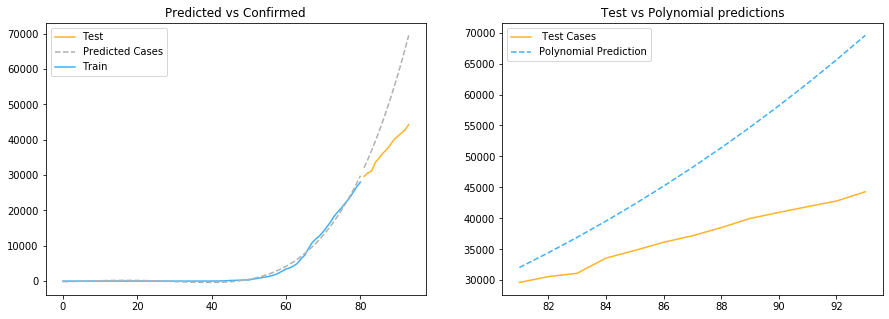

In [25]:
# Transform data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train = poly.fit_transform(np.array(X_train).reshape(-1,1))
poly_X_test = poly.fit_transform(np.array(X_test).reshape(-1,1))

# Linear Regression Model
reg = LinearRegression()

# Train the Model
fit = reg.fit(poly_X_train, np.array(y_train_c).reshape(-1,1))

# Polynomial Regression
y_test_fit = fit.predict(poly_X_test)
y_train_fit = fit.predict(poly_X_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(X_test,y_test_c, label="Test", color=orange)
ax1.plot(X_test, y_test_fit, linestyle='--',label="Predicted Cases", color=lightGrey)
ax1.plot(X_train,y_train_c,label="Train", color=blue)
ax1.plot(X_train, y_train_fit, linestyle='--', color=lightGrey)
ax1.set_title('Predicted vs Confirmed')
ax1.legend()

ax2.plot(X_test,y_test_c,label=" Test Cases", color=orange)
ax2.plot(X_test, y_test_fit, linestyle='--', label="Polynomial Prediction", color=blue)
ax2.set_title('Test vs Polynomial predictions')
ax2.legend()

#### Support Vector Machine 

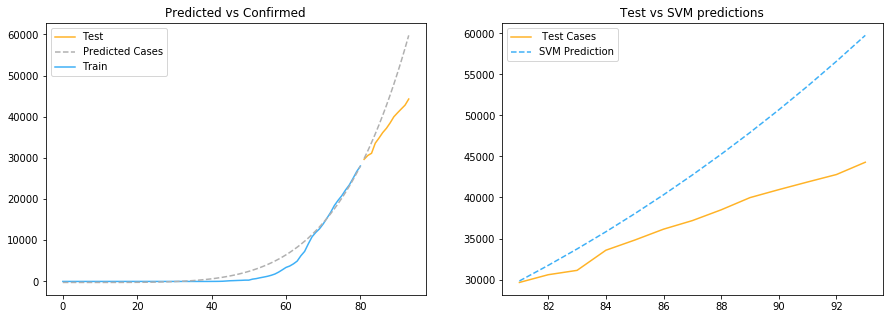

In [26]:
# SVM Regression Model
reg = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)

# Train the Model
fit = reg.fit(np.array(X_train).reshape(-1,1),np.array(y_train_c).reshape(-1,1))

# SVM Regression
y_test_fit = fit.predict(np.array(X_test).reshape(-1,1))
y_train_fit = fit.predict(np.array(X_train).reshape(-1,1))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(X_test,y_test_c, label="Test", color=orange)
ax1.plot(X_test, y_test_fit, linestyle='--',label="Predicted Cases", color=lightGrey)
ax1.plot(X_train,y_train_c,label="Train", color=blue)
ax1.plot(X_train, y_train_fit, linestyle='--', color=lightGrey)
ax1.set_title('Predicted vs Confirmed')
ax1.legend()

ax2.plot(X_test,y_test_c,label=" Test Cases", color=orange)
ax2.plot(X_test, y_test_fit, linestyle='--',label="SVM Prediction", color=blue)
ax2.set_title('Test vs SVM predictions')
ax2.legend()

#### Exponential Regression

##### Curve fitting

In [49]:
data = df.copy()

# Choose a country to predict 
df_country = data[data['Country']=='Belgium']

# Set train/test split for predicition
train_lim = 69
train = df_country[df_country['Days'] <= train_lim]
test = df_country[df_country['Days'] > train_lim]

x = train['Days']
y = train['Confirmed']

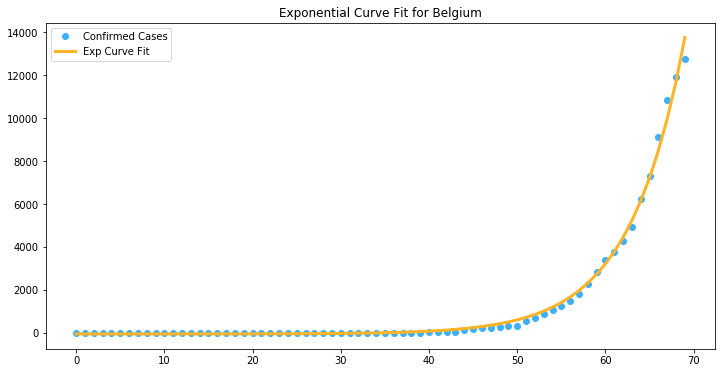

In [74]:
# Set initial conditions
p0 = [4, 0.1, 1] 

# Define fit function
def exponential_function(x, a, b, c):
        return a * np.exp(b * x) + c

# Get optimal parameters for a,b,c,d --> A, B, C, D = popt[0], popt[1], popt[2], popt[3]
(A, B, C), cov = optimize.curve_fit(exponential_function, x, y, p0=p0, maxfev=1000)

y_fit = exponential_function(x, A, B, C)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(x, y, 'o', label='Confirmed Cases', color=blue)
plt.plot(x, y_fit, label='Exp Curve Fit', color=orange,lw=3)
plt.title('Exponential Curve Fit for Belgium')
plt.legend()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y, name='Confirmed Cases', mode='markers', 
#                          marker_color=blue, marker_size=10, marker_line_width=2))
# fig.add_trace(go.Scatter(x=x, y=y_fit, name='Curve Fit', mode='lines', line_width=3, line_color=orange))
# fig.update_layout(title='Exponential Curve Fit for Belgium', xaxis_title='Days', yaxis_title='Confirmed')
# fig.show()

##### Forecasting based on exponential function

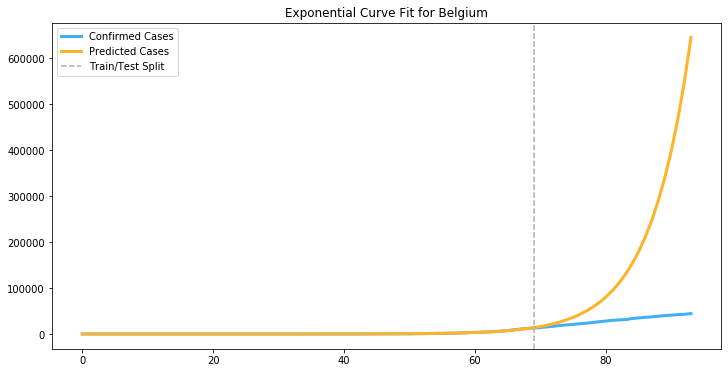

In [73]:
# Exponential Forecast
x_forecast = list(range(len(x)+60))
x_forecast = pd.Series(x_forecast)
forecast = exponential_function(x_forecast, A, B, C)

df_train = df_country['Confirmed']
df_fcst = forecast[:len(df_train)]
dates = list(range(0,len(df_train)))

train_lim = 69
valid_lim = df_country['Days'].max() # To last Update (93 days)
valid_num=valid_lim-train_lim 


# Plot results
plt.figure(figsize=(12,6))
plt.plot(dates, df_train, label='Confirmed Cases', color=blue, lw=3)
plt.plot(dates, df_fcst, label='Predicted Cases', color=orange,lw=3)
plt.axvline(x=69, color=lightGrey, ls='--', label='Train/Test Split')
plt.title('Confirmed vs Predicted for Belgium')
plt.legend()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=dates, y=df_fcst, name='Predicted Cases', mode='lines', line_width=4, line_color=blue))
# fig.add_trace(go.Scatter(x=dates, y=df_train, name='Confirmed Cases', mode='lines', line_width=4, line_color=orange))
# fig.update_layout(title='Confirmed vs Predicted Cases for Belgium"', xaxis_title='Days', yaxis_title='Confirmed')
# fig.add_shape(type= 'line', yref= 'paper', y0= 0, y1= 1, xref= 'x', x0= 69, x1= 69, name='split',
#               line=dict(color=lightGrey, width=2,dash="dash"))
# fig.show()

#### Logistic Regression

##### Curve fitting

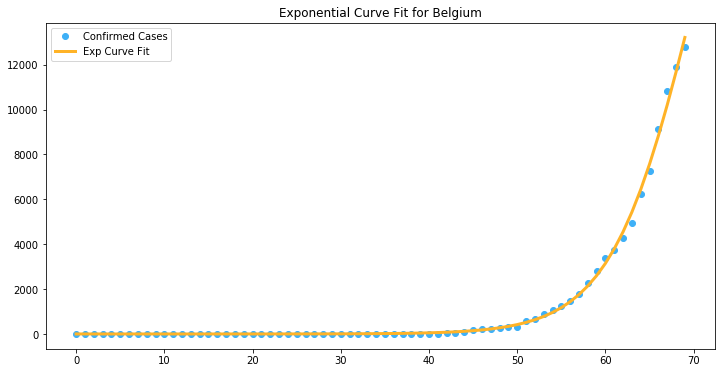

In [75]:
# Set initial conditions
p0 = [0,1,1,0] 

# Define fit function
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

# Get optimal parameters for a,b,c,d --> A, B, C, D = popt[0], popt[1], popt[2], popt[3]
(A, B, C, D), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=1000)
y_fit = logistic_function(x, A, B, C, D)


# Plot results
plt.figure(figsize=(12,6))
plt.plot(x, y, 'o', label='Confirmed Cases', color=blue)
plt.plot(x, y_fit, label='Exp Curve Fit', color=orange,lw=3)
plt.title('Logistic Curve Fit for Belgium')
plt.legend()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y, name='Confirmed Cases', mode='markers', 
#                          marker_color=blue, marker_size=10, marker_line_width=2))
# fig.add_trace(go.Scatter(x=x, y=y_fit, name='Curve Fit', mode='lines', line_width=3, line_color=orange))
# fig.update_layout(title='Logistic Curve Fit for Belgium"', xaxis_title='Days', yaxis_title='Confirmed')
# fig.show()

##### Forecasting based on logistic function

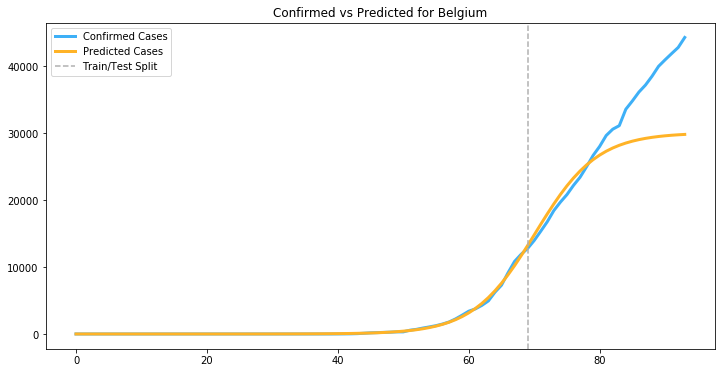

In [76]:
# Logistic Forecast
forecast = logistic_function(list(range(len(x)+60)), A, B, C, D)
df_train = df_country['Confirmed']
df_fcst = forecast[:len(df_train)]
dates = list(range(0,len(df_train)))

train_lim = 69
valid_lim = df_country['Days'].max() # To last Update (93 days)
valid_num=valid_lim-train_lim 


# Plot results
plt.figure(figsize=(12,6))
plt.plot(dates, df_train, label='Confirmed Cases', color=blue, lw=3)
plt.plot(dates, df_fcst, label='Predicted Cases', color=orange,lw=3)
plt.axvline(x=69, color=lightGrey, ls='--', label='Train/Test Split')
plt.title('Confirmed vs Predicted for Belgium')
plt.legend()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=dates, y=df_fcst, name='Predicted Cases', mode='lines', line_width=4, line_color=blue))
# fig.add_trace(go.Scatter(x=dates, y=df_train, name='Confirmed Cases', mode='lines', line_width=4, line_color=orange))
# fig.update_layout(title='Confirmed vs Predicted Cases for Belgium"', xaxis_title='Days', yaxis_title='Confirmed')
# fig.add_shape(type= 'line', yref= 'paper', y0= 0, y1= 1, xref= 'x', x0= 69, x1= 69, name='split',
#               line=dict(color=lightGrey, width=2,dash="dash"))
# fig.show()

#### ARIMA 